In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

### Window width ### Could be adjusted for experimentation ###
window_width = 30  # 30 days


# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2024-02-01') 
val_mask = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500 # Adjusted number of epochs
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        # Scheduler step
        scheduler.step(avg_val_loss)
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():
    # Plot validation predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot test predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import os
import warnings

# ------------------------------------------------------------------
# 1) Reproducibility & Device Setup
# ------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------------------------------------------
# 2) Data Loading & Preprocessing
# ------------------------------------------------------------------
# Update CSV filename as needed
df = pd.read_csv('Gold_Futures_Historical_Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas from numeric fields and convert to float
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Ensure no duplicates or missing values
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to use
features = ['Price','Open','High','Low']
data = df[features].values  # shape (N,4)

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # shape (N,4)

window_size = 30  # rolling window length (days)

# ------------------------------------------------------------------
# 3) Create Rolling Windows (X, y) + Date Array
# ------------------------------------------------------------------
X_all, Y_all, dates_all = [], [], []
for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i - window_size : i])  # shape (30,4)
    Y_all.append(data_scaled[i, 0])  # 'Price' is index 0
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)     # shape (N, 30, 4)
Y_all = np.array(Y_all)     # shape (N,)
dates_all = np.array(dates_all)

# ------------------------------------------------------------------
# 4) Train / Validation / Test Split by Date
# ------------------------------------------------------------------
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert to torch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t,   Y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  Y_test_t),  batch_size=batch_size, shuffle=False)

# ------------------------------------------------------------------
# 5) Define Multiple Model Architectures
# ------------------------------------------------------------------
class BaseModel(nn.Module):
    """
    A single class that can instantiate LSTM, GRU, RNN, CNN, or EnhancedLSTM 
    based on 'model_type'.
    """
    def __init__(self, model_type='LSTM', input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'CNN':
            # For CNN, we use 1D convolutions along the time dimension.
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=hidden_size, kernel_size=3)
            # Each Conv1d with kernel_size=3 reduces length by 2.
            self.conv_output_length = 30 - 2*(3-1)  # = 30 - 4 = 26
            self.fc = nn.Linear(hidden_size * self.conv_output_length, 1)
            
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers+1,  # e.g., one more layer
                batch_first=True,
                dropout=dropout*2
            )
            self.dropout = nn.Dropout(dropout*2)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.fc = nn.Linear(hidden_size, 1)
            
        else:
            raise ValueError("Invalid model_type. Choose from ['LSTM','GRU','RNN','CNN','EnhancedLSTM'].")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            # x: (batch_size, seq_len=30, input_size=4) -> (batch_size, 4, 30)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))  # shape: (batch_size,64,28)
            x = F.relu(self.conv2(x))  # shape: (batch_size, hidden_size, 26)
            x = x.reshape(x.size(0), -1)  # flatten: (batch_size, hidden_size*26)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]         # last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------------------------------------------
# 6) Early Stopping
# ------------------------------------------------------------------
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------
# 7) Inverse Transform for Price
# ------------------------------------------------------------------
def inverse_price_transform(scaled_prices):
    """
    scaled_prices: shape (N,) or (N,1).
    Fill placeholders for the other 3 features to use the same scaler.
    """
    scaled_prices = scaled_prices.reshape(-1, 1)
    zeros = np.zeros((scaled_prices.shape[0], len(features)-1))
    combined = np.hstack([scaled_prices, zeros])  # shape (N,4)
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]  # return Price

# ------------------------------------------------------------------
# 8) Training Function for One-Step-Ahead
# ------------------------------------------------------------------
def train_model(model_name, input_size=4):
    """
    Train a model of type 'model_name' on the training set,
    validate on val_loader, with EarlyStopping.
    Returns the path to the saved best checkpoint.
    """
    model = BaseModel(model_type=model_name, input_size=input_size).to(device)
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30)
    early_stopper = EarlyStopping(patience=30, min_delta=0.0)
    
    best_val_loss = float('inf')
    best_path = f"best_model_{model_name}.pt"
    
    epochs = 300
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                val_preds = model(Xb)
                val_loss = criterion(val_preds, Yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        
        scheduler.step(avg_val_loss)
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print(f"{model_name}: Early stopping at epoch {epoch+1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)
        
        if (epoch+1) % 50 == 0:
            print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    return best_path

# ------------------------------------------------------------------
# 9) Walk-Forward with Fine-Tuning (Incremental Updates)
# ------------------------------------------------------------------
def walk_forward_finetune(model, data_scaled, dates, start_idx, end_idx, window=30, epochs_per_update=1, lr=1e-4):
    """
    Walk-forward forecast from start_idx to end_idx-1:
      - Predict day t using previous (window) days of data (which may be predicted).
      - Once day t's actual price is known, perform a small incremental update.
      - Move to day t+1.
    
    Returns:
      preds_scaled: 1D numpy array of predicted prices (scaled) for days in [start_idx, end_idx)
      actual_scaled: 1D numpy array of actual prices (scaled)
      forecast_dates: numpy array of corresponding timestamps.
    """
    # Set up a small optimizer for incremental updates.
    inc_optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    model.eval()
    
    preds_scaled = []
    actual_scaled = []
    forecast_dates = []
    
    # Start with the last 'window' days (real data) before start_idx.
    current_window = data_scaled[start_idx - window : start_idx].copy()
    
    for t in range(start_idx, end_idx):
        # 1) Pure prediction for day t.
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, window, 4)
        with torch.no_grad():
            y_pred_t = model(X_in).cpu().numpy().flatten()[0]
        preds_scaled.append(y_pred_t)
        forecast_dates.append(dates[t])
        
        # 2) Record actual scaled price for day t.
        y_true_t = data_scaled[t, 0]
        actual_scaled.append(y_true_t)
        
        # 3) Shift window forward: remove oldest day, append predicted day's features.
        current_window = current_window[1:]
        next_day_features = np.array([y_pred_t] * 4)
        current_window = np.vstack([current_window, next_day_features])
        
        # 4) Fine-tune with the new actual data.
        # Use the same input X_in and target y_true_t.
        X_update = X_in  # shape: (1, window, 4)
        Y_update = torch.tensor([[y_true_t]], dtype=torch.float32, device=device)  # shape: (1,1)
        
        model.train()
        for _ in range(epochs_per_update):
            inc_optimizer.zero_grad()
            # For EnhancedLSTM (with BatchNorm), replicate X_update to simulate batch size > 1.
            if hasattr(model, 'model_type') and model.model_type == 'EnhancedLSTM':
                X_update_rep = X_update.repeat(2, 1, 1)  # now batch size 2
                Y_update_rep = Y_update.repeat(2, 1)
                out = model(X_update_rep)
                loss = loss_fn(out, Y_update_rep)
            else:
                out = model(X_update)
                loss = loss_fn(out, Y_update)
            loss.backward()
            inc_optimizer.step()
        model.eval()
    
    return np.array(preds_scaled), np.array(actual_scaled), np.array(forecast_dates)

# ------------------------------------------------------------------
# 10) Train All Models & Evaluate with Walk-Forward Fine-Tuning
# ------------------------------------------------------------------
model_types = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
best_paths = {}

print("======= Training All Models (One-Step-Ahead) =======")
for mtype in model_types:
    print(f"\nTraining {mtype}...")
    best_paths[mtype] = train_model(mtype, input_size=4)

# Full scaled data and corresponding date array.
data_scaled_full = data_scaled  # shape (N,4)
dates_full = df['Date'].values   # shape (N,)

# Determine indices for validation and test in the full data.
val_start_idx = np.where(dates_full == val_dates[0])[0][0] if len(val_dates) > 0 else None
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1 if len(val_dates) > 0 else None
test_start_idx = np.where(dates_full == test_dates[0])[0][0] if len(test_dates) > 0 else None
test_end_idx   = np.where(dates_full == test_dates[-1])[0][0] + 1 if len(test_dates) > 0 else None

results = {}

print("\n======= Walk-Forward Predictions with Fine-Tuning =======")
for mtype in model_types:
    print(f"\n--- Model: {mtype} ---")
    # Load best checkpoint.
    model = BaseModel(model_type=mtype, input_size=4).to(device)
    model.load_state_dict(torch.load(best_paths[mtype], map_location=device))
    
    # Walk-forward on the Validation window.
    if val_start_idx is not None and val_end_idx is not None:
        val_preds_scaled, val_actual_scaled, val_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=val_start_idx,
            end_idx=val_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        val_preds_inv = inverse_price_transform(val_preds_scaled)
        val_actual_inv = inverse_price_transform(val_actual_scaled)
        val_mape = mean_absolute_percentage_error(val_actual_inv, val_preds_inv) * 100
        print(f"{mtype} Validation MAPE: {val_mape:.2f}%")
    else:
        val_preds_inv, val_actual_inv, val_forecast_dates = [], [], []
        val_mape = None
    
    # Walk-forward on the Test window.
    if test_start_idx is not None and test_end_idx is not None:
        test_preds_scaled, test_actual_scaled, test_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=test_start_idx,
            end_idx=test_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        test_preds_inv = inverse_price_transform(test_preds_scaled)
        test_actual_inv = inverse_price_transform(test_actual_scaled)
        test_mape = mean_absolute_percentage_error(test_actual_inv, test_preds_inv) * 100
        print(f"{mtype} Test MAPE:       {test_mape:.2f}%")
    else:
        test_preds_inv, test_actual_inv, test_forecast_dates = [], [], []
        test_mape = None
    
    results[mtype] = {
        'val_forecast_dates': val_forecast_dates,
        'val_preds_inv': val_preds_inv,
        'val_actual_inv': val_actual_inv,
        'val_mape': val_mape,
        'test_forecast_dates': test_forecast_dates,
        'test_preds_inv': test_preds_inv,
        'test_actual_inv': test_actual_inv,
        'test_mape': test_mape
    }

# ------------------------------------------------------------------
# 11) Plot Results for Each Model
# ------------------------------------------------------------------
plt.figure(figsize=(14,8))
plt.plot(dates_full, inverse_price_transform(data_scaled_full[:,0]), label='Historical Price', color='black')

colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple'
}

for mtype in model_types:
    # Plot Validation Predictions (dashed lines)
    if len(results[mtype]['val_forecast_dates']) > 0:
        plt.plot(results[mtype]['val_forecast_dates'],
                 results[mtype]['val_preds_inv'],
                 label=f"{mtype} Val Pred",
                 color=colors[mtype],
                 linestyle='--')
    # Plot Test Predictions (solid lines)
    if len(results[mtype]['test_forecast_dates']) > 0:
        plt.plot(results[mtype]['test_forecast_dates'],
                 results[mtype]['test_preds_inv'],
                 label=f"{mtype} Test Pred",
                 color=colors[mtype])
    
plt.title("All Models: Walk-Forward Predictions with Fine-Tuning")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
======= Training All Models (One-Step-Ahead) =======

Training LSTM...
Early stopping triggered!
LSTM: Early stopping at epoch 48

Training GRU...
[GRU] Epoch 50/300 | Train Loss: 0.000148 | Val Loss: 0.000282
Early stopping triggered!
GRU: Early stopping at epoch 78

Training RNN...
[RNN] Epoch 50/300 | Train Loss: 0.000158 | Val Loss: 0.003806
[RNN] Epoch 100/300 | Train Loss: 0.000167 | Val Loss: 0.002658
[RNN] Epoch 150/300 | Train Loss: 0.000140 | Val Loss: 0.002181
[RNN] Epoch 200/300 | Train Loss: 0.000138 | Val Loss: 0.001824
[RNN] Epoch 250/300 | Train Loss: 0.000122 | Val Loss: 0.000331
Early stopping triggered!
RNN: Early stopping at epoch 288

Training EnhancedLSTM...
[EnhancedLSTM] Epoch 50/300 | Train Loss: 0.004105 | Val Loss: 0.005678
[EnhancedLSTM] Epoch 100/300 | Train Loss: 0.003668 | Val Loss: 0.000967
Early stopping triggered!
EnhancedLSTM: Early stopping at epoch 111

======= Walk-Forward Predictions with Fine-Tuning =======

--- Model: LSTM ---

/tmp/ipykernel_1186759/1468755624.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


LSTM Validation MAPE: 8.85%
LSTM Test MAPE:       3.33%

--- Model: GRU ---


/tmp/ipykernel_1186759/1468755624.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


GRU Validation MAPE: 8.00%
GRU Test MAPE:       4.88%

--- Model: RNN ---


/tmp/ipykernel_1186759/1468755624.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


RNN Validation MAPE: 7.58%
RNN Test MAPE:       4.66%

--- Model: EnhancedLSTM ---


/tmp/ipykernel_1186759/1468755624.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_paths[mtype], map_location=device))


EnhancedLSTM Validation MAPE: 11.76%
EnhancedLSTM Test MAPE:       17.23%


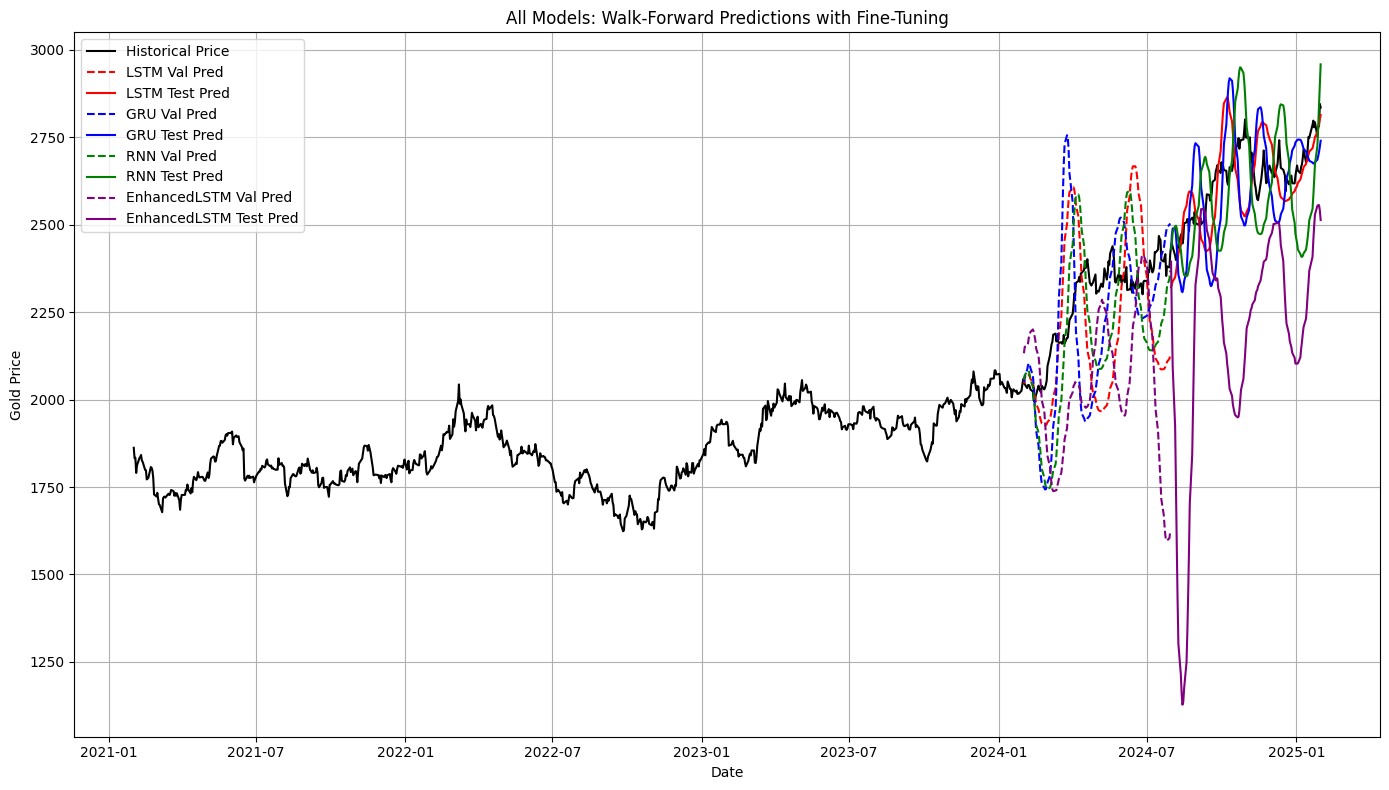

/tmp/ipykernel_1186759/1468755624.py:514: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fut_model.load_state_dict(torch.load(best_paths[mtype], map_location=device))
/tmp/ip

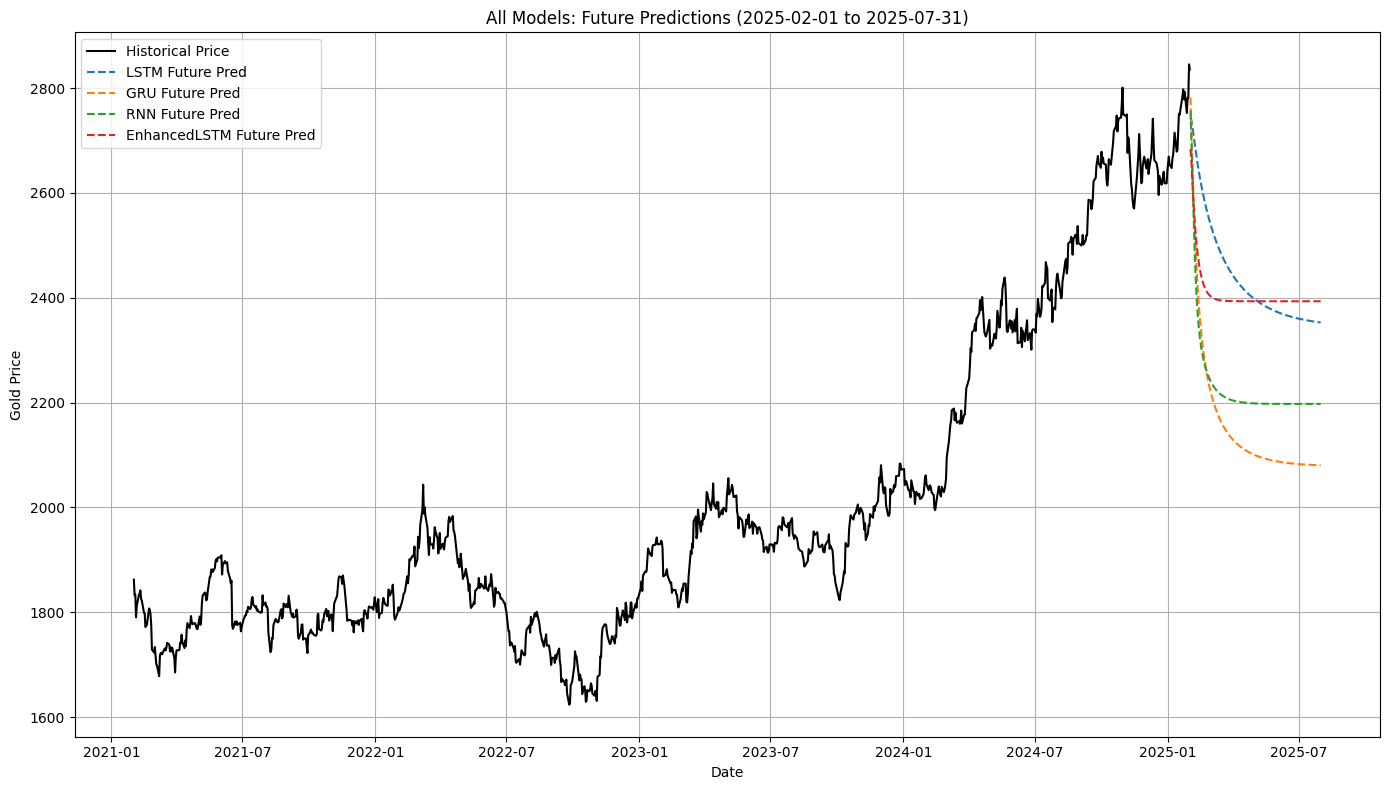

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import os
import warnings

# ------------------------------------------------------------------
# 1) Reproducibility & Device Setup
# ------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ------------------------------------------------------------------
# 2) Data Loading & Preprocessing
# ------------------------------------------------------------------
# Update CSV filename as needed
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas from numeric fields and convert to float
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Ensure no duplicates or missing values
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to use
features = ['Price','Open','High','Low']
data = df[features].values  # shape (N,4)

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # shape (N,4)

window_size = 30  # rolling window length (days)

# ------------------------------------------------------------------
# 3) Create Rolling Windows (X, y) + Date Array
# ------------------------------------------------------------------
X_all, Y_all, dates_all = [], [], []
for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i - window_size : i])  # shape (30,4)
    Y_all.append(data_scaled[i, 0])  # 'Price' is index 0
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)     # shape (N, 30, 4)
Y_all = np.array(Y_all)     # shape (N,)
dates_all = np.array(dates_all)

# ------------------------------------------------------------------
# 4) Train / Validation / Test Split by Date
# ------------------------------------------------------------------
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert to torch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t,   Y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  Y_test_t),  batch_size=batch_size, shuffle=False)

# ------------------------------------------------------------------
# 5) Define Multiple Model Architectures
# ------------------------------------------------------------------
class BaseModel(nn.Module):
    """
    A single class that can instantiate LSTM, GRU, RNN, CNN, or EnhancedLSTM 
    based on 'model_type'.
    """
    def __init__(self, model_type='LSTM', input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout
            )
            self.fc = nn.Linear(hidden_size, 1)
            
        elif model_type == 'CNN':
            # For CNN, we use 1D convolutions along the time dimension.
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=hidden_size, kernel_size=3)
            # Each Conv1D with kernel_size=3 reduces length by 2.
            self.conv_output_length = 30 - 2*(3-1)  # = 30 - 4 = 26
            self.fc = nn.Linear(hidden_size * self.conv_output_length, 1)
            
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers+1,  # e.g., one more layer
                batch_first=True,
                dropout=dropout*2
            )
            self.dropout = nn.Dropout(dropout*2)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.fc = nn.Linear(hidden_size, 1)
            
        else:
            raise ValueError("Invalid model_type. Choose from ['LSTM','GRU','RNN','CNN','EnhancedLSTM'].")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            # x: (batch_size, seq_len=30, input_size=4) -> (batch_size, 4, 30)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))  # shape: (batch_size,64,28)
            x = F.relu(self.conv2(x))  # shape: (batch_size, hidden_size, 26)
            x = x.reshape(x.size(0), -1)  # flatten: (batch_size, hidden_size*26)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]         # last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------------------------------------------
# 6) Early Stopping
# ------------------------------------------------------------------
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------
# 7) Inverse Transform for Price
# ------------------------------------------------------------------
def inverse_price_transform(scaled_prices):
    """
    scaled_prices: shape (N,) or (N,1).
    Fill placeholders for the other 3 features to use the same scaler.
    """
    scaled_prices = scaled_prices.reshape(-1, 1)
    zeros = np.zeros((scaled_prices.shape[0], len(features)-1))
    combined = np.hstack([scaled_prices, zeros])  # shape (N,4)
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]  # return Price

# ------------------------------------------------------------------
# 8) Training Function for One-Step-Ahead
# ------------------------------------------------------------------
def train_model(model_name, input_size=4):
    """
    Train a model of type 'model_name' on the training set,
    validate on val_loader, with EarlyStopping.
    Returns the path to the saved best checkpoint.
    """
    model = BaseModel(model_type=model_name, input_size=input_size).to(device)
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30)
    early_stopper = EarlyStopping(patience=30, min_delta=0.0)
    
    best_val_loss = float('inf')
    best_path = f"best_model_{model_name}.pt"
    
    epochs = 300
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                val_preds = model(Xb)
                val_loss = criterion(val_preds, Yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        
        scheduler.step(avg_val_loss)
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print(f"{model_name}: Early stopping at epoch {epoch+1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)
        
        if (epoch+1) % 50 == 0:
            print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    return best_path

# ------------------------------------------------------------------
# 9) Walk-Forward with Fine-Tuning (Incremental Updates)
# ------------------------------------------------------------------
def walk_forward_finetune(model, data_scaled, dates, start_idx, end_idx, window=30, epochs_per_update=1, lr=1e-4):
    """
    Walk-forward forecast from start_idx to end_idx-1:
      - Predict day t using previous (window) days of data (which may be predicted).
      - Once day t's actual price is known, perform a small incremental update.
      - Move to day t+1.
    
    Returns:
      preds_scaled: 1D numpy array of predicted prices (scaled) for days in [start_idx, end_idx)
      actual_scaled: 1D numpy array of actual prices (scaled)
      forecast_dates: numpy array of corresponding timestamps.
    """
    # Set up a small optimizer for incremental updates.
    inc_optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    model.eval()
    
    preds_scaled = []
    actual_scaled = []
    forecast_dates = []
    
    # Start with the last 'window' days (real data) before start_idx.
    current_window = data_scaled[start_idx - window : start_idx].copy()
    
    for t in range(start_idx, end_idx):
        # 1) Pure prediction for day t.
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, window, 4)
        with torch.no_grad():
            y_pred_t = model(X_in).cpu().numpy().flatten()[0]
        preds_scaled.append(y_pred_t)
        forecast_dates.append(dates[t])
        
        # 2) Record actual scaled price for day t.
        y_true_t = data_scaled[t, 0]
        actual_scaled.append(y_true_t)
        
        # 3) Shift window forward: remove oldest day, append predicted day's features.
        current_window = current_window[1:]
        next_day_features = np.array([y_pred_t] * 4)
        current_window = np.vstack([current_window, next_day_features])
        
        # 4) Fine-tune with the new actual data.
        # Use the same input X_in and target y_true_t.
        X_update = X_in  # shape: (1, window, 4)
        Y_update = torch.tensor([[y_true_t]], dtype=torch.float32, device=device)  # shape: (1,1)
        
        model.train()
        for _ in range(epochs_per_update):
            inc_optimizer.zero_grad()
            # For EnhancedLSTM (with BatchNorm), replicate X_update to simulate batch size > 1 if needed.
            if hasattr(model, 'model_type') and model.model_type == 'EnhancedLSTM':
                X_update_rep = X_update.repeat(2, 1, 1)  # batch size = 2
                Y_update_rep = Y_update.repeat(2, 1)
                out = model(X_update_rep)
                loss = loss_fn(out, Y_update_rep)
            else:
                out = model(X_update)
                loss = loss_fn(out, Y_update)
            loss.backward()
            inc_optimizer.step()
        model.eval()
    
    return np.array(preds_scaled), np.array(actual_scaled), np.array(forecast_dates)

# ------------------------------------------------------------------
# 10) Train All Models & Evaluate with Walk-Forward Fine-Tuning
# ------------------------------------------------------------------
model_types = ['LSTM', 'GRU', 'RNN', 'EnhancedLSTM']
best_paths = {}

print("======= Training All Models (One-Step-Ahead) =======")
for mtype in model_types:
    print(f"\nTraining {mtype}...")
    best_paths[mtype] = train_model(mtype, input_size=4)

# Full scaled data and corresponding date array.
data_scaled_full = data_scaled  # shape (N,4)
dates_full = df['Date'].values   # shape (N,)

# Determine indices for validation and test in the full data.
val_start_idx = np.where(dates_full == val_dates[0])[0][0] if len(val_dates) > 0 else None
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1 if len(val_dates) > 0 else None
test_start_idx = np.where(dates_full == test_dates[0])[0][0] if len(test_dates) > 0 else None
test_end_idx   = np.where(dates_full == test_dates[-1])[0][0] + 1 if len(test_dates) > 0 else None

results = {}

print("\n======= Walk-Forward Predictions with Fine-Tuning =======")
for mtype in model_types:
    print(f"\n--- Model: {mtype} ---")
    # Load best checkpoint.
    model = BaseModel(model_type=mtype, input_size=4).to(device)
    model.load_state_dict(torch.load(best_paths[mtype], map_location=device))
    
    # Walk-forward on the Validation window.
    if val_start_idx is not None and val_end_idx is not None:
        val_preds_scaled, val_actual_scaled, val_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=val_start_idx,
            end_idx=val_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        val_preds_inv = inverse_price_transform(val_preds_scaled)
        val_actual_inv = inverse_price_transform(val_actual_scaled)
        val_mape = mean_absolute_percentage_error(val_actual_inv, val_preds_inv) * 100
        print(f"{mtype} Validation MAPE: {val_mape:.2f}%")
    else:
        val_preds_inv, val_actual_inv, val_forecast_dates = [], [], []
        val_mape = None
    
    # Walk-forward on the Test window.
    if test_start_idx is not None and test_end_idx is not None:
        test_preds_scaled, test_actual_scaled, test_forecast_dates = walk_forward_finetune(
            model,
            data_scaled_full,
            dates_full,
            start_idx=test_start_idx,
            end_idx=test_end_idx,
            window=window_size,
            epochs_per_update=1,
            lr=1e-4
        )
        test_preds_inv = inverse_price_transform(test_preds_scaled)
        test_actual_inv = inverse_price_transform(test_actual_scaled)
        test_mape = mean_absolute_percentage_error(test_actual_inv, test_preds_inv) * 100
        print(f"{mtype} Test MAPE:       {test_mape:.2f}%")
    else:
        test_preds_inv, test_actual_inv, test_forecast_dates = [], [], []
        test_mape = None
    
    results[mtype] = {
        'val_forecast_dates': val_forecast_dates,
        'val_preds_inv': val_preds_inv,
        'val_actual_inv': val_actual_inv,
        'val_mape': val_mape,
        'test_forecast_dates': test_forecast_dates,
        'test_preds_inv': test_preds_inv,
        'test_actual_inv': test_actual_inv,
        'test_mape': test_mape
    }

# ------------------------------------------------------------------
# 11) Plot Historical, Validation, and Test Predictions
# ------------------------------------------------------------------
plt.figure(figsize=(14,8))
plt.plot(dates_full, inverse_price_transform(data_scaled_full[:,0]), label='Historical Price', color='black')

colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'EnhancedLSTM': 'purple'
}

for mtype in model_types:
    # Plot Validation Predictions (dashed lines)
    if len(results[mtype]['val_forecast_dates']) > 0:
        plt.plot(results[mtype]['val_forecast_dates'],
                 results[mtype]['val_preds_inv'],
                 label=f"{mtype} Val Pred",
                 color=colors[mtype],
                 linestyle='--')
    # Plot Test Predictions (solid lines)
    if len(results[mtype]['test_forecast_dates']) > 0:
        plt.plot(results[mtype]['test_forecast_dates'],
                 results[mtype]['test_preds_inv'],
                 label=f"{mtype} Test Pred",
                 color=colors[mtype])
    
plt.title("All Models: Walk-Forward Predictions with Fine-Tuning")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 12) Extend Predictions to the Future Mask (2025-02-01 to 2025-07-31)
# ------------------------------------------------------------------
def walk_forward_future(model, last_30_window, future_dates):
    """
    Predict future gold prices day-by-day, with NO actual data for updates.
    model:       your trained model (in eval mode).
    last_30_window: the final 30 days of scaled data from your dataset (shape: (30,4)).
    future_dates: array or pd.date_range of future dates to predict.
    
    Returns:
      future_preds_scaled: predictions in scaled form, shape (len(future_dates),)
      future_preds_inv:    predictions in original scale
    """
    model.eval()
    current_window = last_30_window.copy()  # shape (30,4)
    future_preds_scaled = []
    
    with torch.no_grad():
        for _ in range(len(future_dates)):
            X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(X_in)  # shape: (1,1)
            pred_val = pred.cpu().numpy().flatten()[0]  # scaled Price
            future_preds_scaled.append(pred_val)
            # Shift window
            current_window = current_window[1:]  # drop oldest day
            # replicate predicted Price for open/high/low
            next_day_features = np.array([pred_val]*4)
            current_window = np.vstack([current_window, next_day_features])
    
    future_preds_scaled = np.array(future_preds_scaled)
    future_preds_inv = inverse_price_transform(future_preds_scaled)
    return future_preds_scaled, future_preds_inv

# We'll forecast from 2025-02-01 to 2025-07-31
future_start_date = pd.to_datetime("2025-02-01")
future_end_date   = pd.to_datetime("2025-07-31")
future_date_range = pd.date_range(start=future_start_date, end=future_end_date, freq='D')

# Take the last 30 days from your entire dataset as the seed window
# i.e. from the final row (len(data_scaled)-1) backward 30 days
last_30_window = data_scaled[-window_size:]  # shape: (30,4)

# Create a new figure for future predictions
plt.figure(figsize=(14,8))
# Plot the historical Price
plt.plot(dates_full, inverse_price_transform(data_scaled_full[:,0]), label='Historical Price', color='black')

for mtype in model_types:
    # Load the best checkpoint again to get a fresh model
    fut_model = BaseModel(model_type=mtype, input_size=4).to(device)
    fut_model.load_state_dict(torch.load(best_paths[mtype], map_location=device))
    
    # Perform pure multi-step forecast for the future range (2025-02-01 -> 2025-07-31)
    fut_preds_scaled, fut_preds_inv = walk_forward_future(fut_model, last_30_window, future_date_range)
    
    plt.plot(future_date_range, fut_preds_inv, label=f"{mtype} Future Pred", linestyle='--')

plt.title("All Models: Future Predictions (2025-02-01 to 2025-07-31)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
